<a href="https://colab.research.google.com/github/Alex-U02/Zajecia/blob/main/Analiza_zbioru_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train size: 712, Test size: 179

--- Wyniki drzew decyzyjnych ---
  max_depth  Accuracy  Precision    Recall        F1
0         2  0.759777   0.861111  0.449275  0.590476
1         3  0.793296   0.863636  0.550725  0.672566
2         5  0.765363   0.754717  0.579710  0.655738
3         7  0.804469   0.814815  0.637681  0.715447
4        10  0.798883   0.761905  0.695652  0.727273
5      None  0.821229   0.793651  0.724638  0.757576

Najlepsze max_depth: None (F1=0.7576)


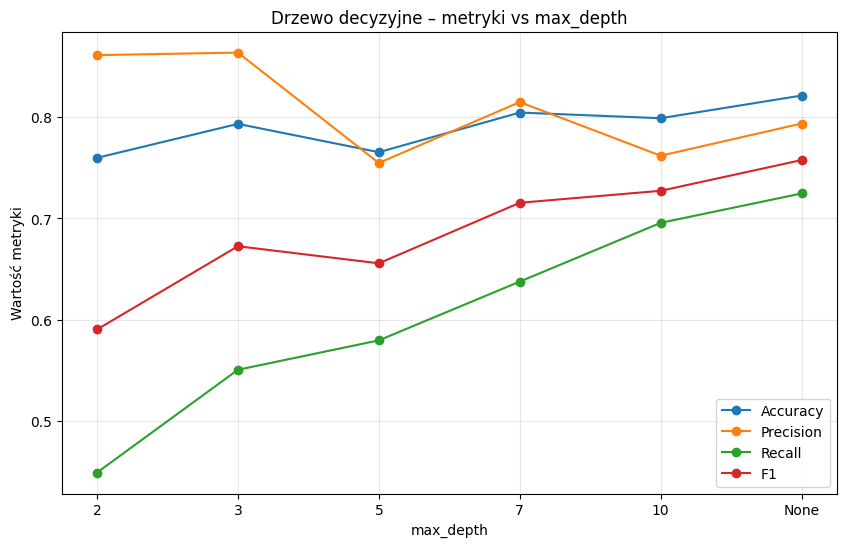

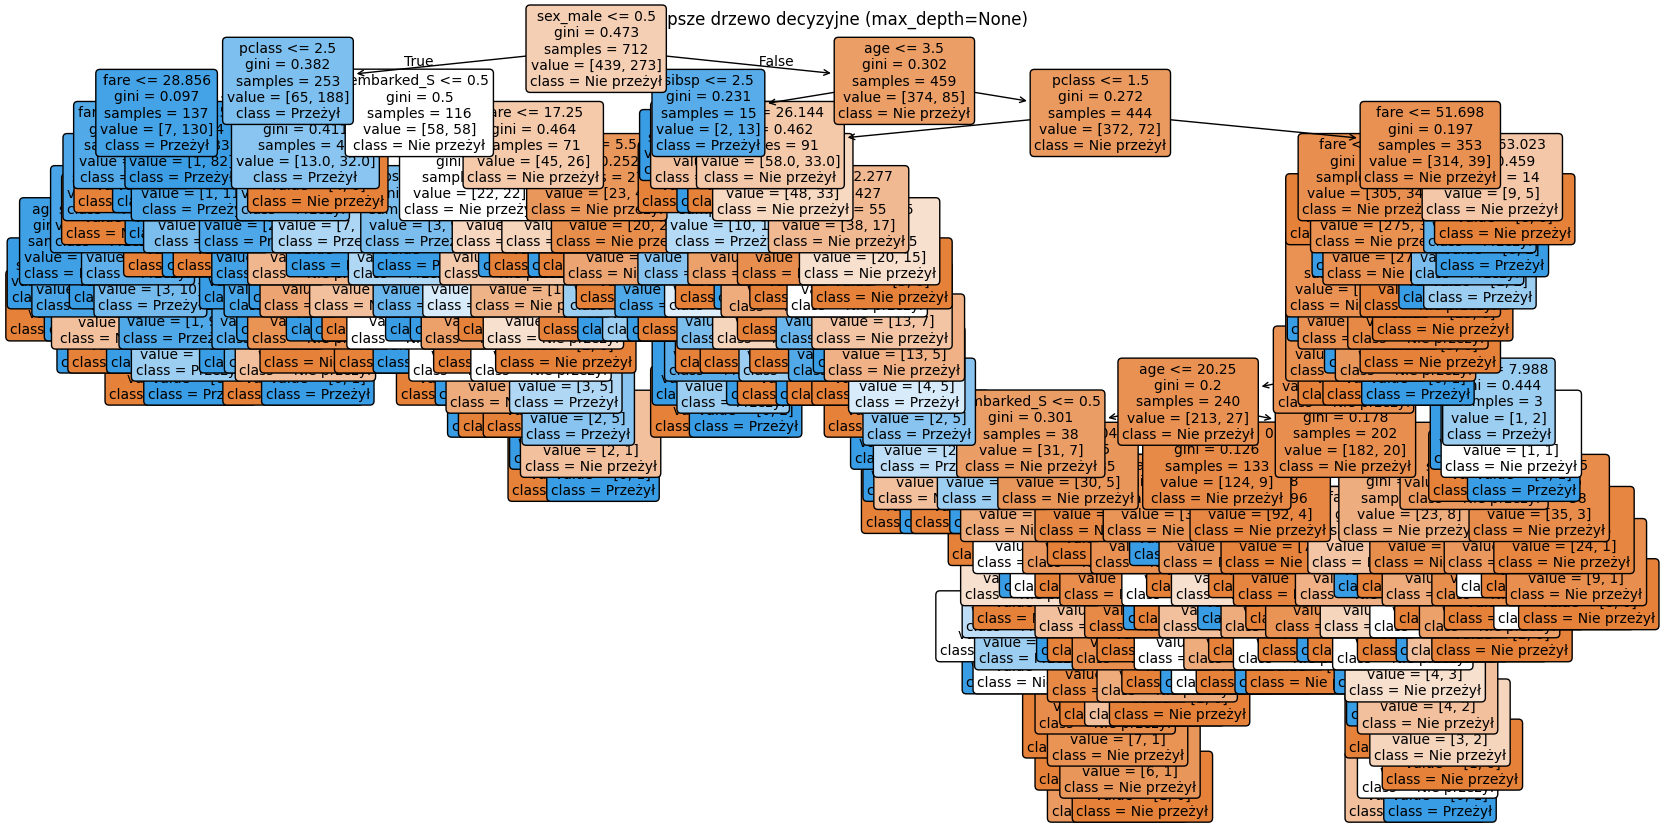


--- Ważność cech ---
        Cecha   Ważność
5    sex_male  0.316638
1         age  0.266991
4        fare  0.227918
0      pclass  0.110281
7  embarked_S  0.032651
3       parch  0.021010
2       sibsp  0.019053
6  embarked_Q  0.005458

--- Wyniki KNN ---
    k  Accuracy  Precision    Recall        F1
0   1  0.748603   0.657895  0.724638  0.689655
1   3  0.810056   0.753623  0.753623  0.753623
2   5  0.815642   0.800000  0.695652  0.744186
3   7  0.821229   0.784615  0.739130  0.761194
4   9  0.804469   0.793103  0.666667  0.724409
5  11  0.804469   0.793103  0.666667  0.724409
6  15  0.821229   0.824561  0.681159  0.746032

Optymalne k: 7 (Accuracy=0.8212)


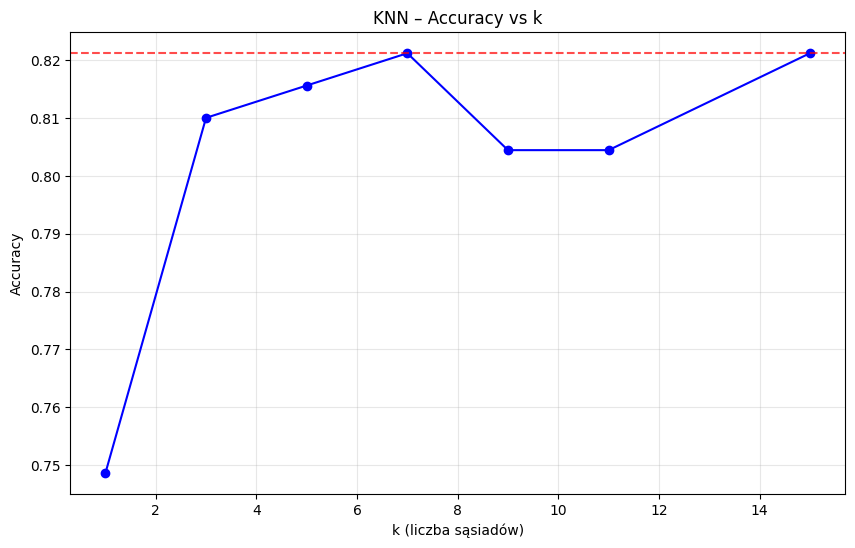


--- Porównanie najlepszych modeli ---
Accuracy: Drzewo=0.8212, KNN=0.8212 → Remis
Precision: Drzewo=0.7937, KNN=0.7846 → Drzewo
Recall: Drzewo=0.7246, KNN=0.7391 → KNN
F1: Drzewo=0.7576, KNN=0.7612 → KNN

Podsumowanie:
Drzewo decyzyjne (max_depth=None) – interpretowalne, najważniejsze cechy: sex_male, age
KNN (k=7) – prosty, wymaga normalizacji, osiąga podobną skuteczność (~0.82)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Wczytanie i przygotowanie danych
df = sns.load_dataset("titanic")
df_clean = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].copy()

df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())
df_clean['embarked'] = df_clean['embarked'].fillna(df_clean['embarked'].mode()[0])

df_encoded = pd.get_dummies(df_clean, columns=['sex', 'embarked'], drop_first=True)

X = df_encoded.drop('survived', axis=1)
y = df_encoded['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# 2. Drzewo decyzyjne – eksperymenty z max_depth
max_depths = [2, 3, 5, 7, 10, None]
tree_results = []

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    metrics = {
        'max_depth': depth if depth else 'None',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    tree_results.append(metrics)

tree_df = pd.DataFrame(tree_results)
best_tree_idx = tree_df['F1'].idxmax()
best_depth = max_depths[best_tree_idx]
best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42).fit(X_train, y_train)

print("\n--- Wyniki drzew decyzyjnych ---")
print(tree_df)
print(f"\nNajlepsze max_depth: {best_depth} (F1={tree_df.loc[best_tree_idx,'F1']:.4f})")

x_labels = [str(d) if d is not None else 'None' for d in max_depths]
x_pos = range(len(max_depths))

plt.figure(figsize=(10,6))
for metric in ['Accuracy','Precision','Recall','F1']:
    plt.plot(x_pos, tree_df[metric], marker='o', label=metric)

plt.xticks(x_pos, x_labels)
plt.xlabel("max_depth")
plt.ylabel("Wartość metryki")
plt.title("Drzewo decyzyjne – metryki vs max_depth")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(20,10))
plot_tree(best_tree,
          feature_names=X.columns,
          class_names=['Nie przeżył','Przeżył'],
          filled=True, rounded=True, fontsize=10)
plt.title(f"Najlepsze drzewo decyzyjne (max_depth={best_depth})")
plt.show()

importance_df = pd.DataFrame({
    'Cecha': X.columns,
    'Ważność': best_tree.feature_importances_
}).sort_values('Ważność', ascending=False)
print("\n--- Ważność cech ---")
print(importance_df)

# 3. KNN – eksperymenty z różnymi k
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_values = [1, 3, 5, 7, 9, 11, 15]
knn_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    metrics = {
        'k': k,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    knn_results.append(metrics)

knn_df = pd.DataFrame(knn_results)
best_knn_idx = knn_df['Accuracy'].idxmax()
best_k = k_values[best_knn_idx]

print("\n--- Wyniki KNN ---")
print(knn_df)
print(f"\nOptymalne k: {best_k} (Accuracy={knn_df.loc[best_knn_idx,'Accuracy']:.4f})")

plt.figure(figsize=(10,6))
plt.plot(knn_df['k'], knn_df['Accuracy'], 'b-o')
plt.axhline(knn_df['Accuracy'].max(), color='r', linestyle='--', alpha=0.7)
plt.xlabel("k (liczba sąsiadów)")
plt.ylabel("Accuracy")
plt.title("KNN – Accuracy vs k")
plt.grid(alpha=0.3)
plt.show()

# 4. Porównanie modeli
print("\n--- Porównanie najlepszych modeli ---")
best_tree_metrics = tree_df.loc[best_tree_idx]
best_knn_metrics = knn_df.loc[best_knn_idx]

for metric in ['Accuracy','Precision','Recall','F1']:
    t_val = best_tree_metrics[metric]
    k_val = best_knn_metrics[metric]
    winner = "Drzewo" if t_val > k_val else "KNN" if k_val > t_val else "Remis"
    print(f"{metric}: Drzewo={t_val:.4f}, KNN={k_val:.4f} → {winner}")

print("\nPodsumowanie:")
print(f"Drzewo decyzyjne (max_depth={best_depth}) – interpretowalne, najważniejsze cechy: "
      f"{importance_df.iloc[0]['Cecha']}, {importance_df.iloc[1]['Cecha']}")
print(f"KNN (k={best_k}) – prosty, wymaga normalizacji, osiąga podobną skuteczność (~{knn_df['Accuracy'].max():.2f})")
